# Training tutorial

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch_geometric
import yaml

import jeans_gnn as jgnn

%matplotlib inline

/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read the dataset

As a first step, we read the preprocessed dataset of projected galaxy kinematics.
For each galaxy, we will construct a k-nearest neighbor graph.

In [2]:
# Read the training and validation datasets
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'labels'])
num_galaxies = headers['num_galaxies']

# print all headers of the training dataset
print('Headers:')
for k, v in headers.items():
    print('- {}: {}'.format(k, v))

Headers:
- all_features: ['pos' 'vel' 'vel_error' 'dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm'
 'dm_rho_0' 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- dataset_name: mini_gNFW_Plummer_OM_poisson100
- date: 2023-04-14 11:23:34
- df_type: QuasiSpherical
- dm_type: Spheroid
- error_los: 0
- flag: valid
- galaxy_name: mini_gNFW_Plummer_OM_poisson100
- graph_features: ['dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm' 'dm_rho_0'
 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- labels_order: ['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
- name: mini
- node_features: ['pos' 'vel' 'vel_error']
- num_galaxies: 100
- projection: 0
- stellar_type: Plummer
- train_frac: 0.9


In this example, there are 100 galaxies. 

Each galaxy has a different number of stars. The node features of each star are:
- `pos`: the 2D position of the galaxy
- `vel`: the line-of-sight velocity of the galaxy
- `vel_err`: the error on the line-of-sight velocity of the galaxy

The labels are stored in `graph_features['labels']`, which is a (N, 6) dimensional
array with label ordering:
- `dm_gamma`: inner slope of the gNFW profile
- `dm_log_r_dm`: the log10 of the scale radius of the gNFW profile
- `dm_log_rho_0`: the log10 of the central density of the gNFW profile
- `stellar_log_r_star`: the log10 of the scale radius of the Plummer profile
- `df_beta_0`: the normalization of the Osipkov-Merritt DF velocity anisotropy
- `df_log_r_a`: the log10 of the scale radius of the Osipkov-Merritt DF

In [3]:
# print the node features of the first 10 stars in the first galaxy
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

print("Graph features:")
print(headers['labels_order'])
print("- labels: {}".format(graph_features['labels'][0]))

Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]
Graph features:
['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
- labels: [ 1.79551026 -0.94841769  6.9007755  -1.12356432 -0.18195041 -0.90968556]


The node features include the position and line-of-sight velocity of each star
in the galaxy. From this, we can construct a k-nearest neighbor graph.

In this example, we set k=5, which means that each star is connected to its
5 nearest neighbors.

In [4]:
# Construct an object for data transformation
# graph construction based on torch_geometric.transforms.KNNGraph
# https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.KNNGraph
transform = jgnn.gnn.transforms.PhaseSpaceGraphProcessor(
    graph_name="KNNGraph",
    graph_params={
        "k": 5, 
        "force_undirected": True, 
        "loop": False
    },
    log_radius=True,
)

In [5]:
# Iterate over the training dataset
# and transform each graph to torch_geometric.data.Data
# https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
data_list = []
for i in range(num_galaxies):
    data = transform(
        pos=node_features['pos'][i],
        vel=node_features['vel'][i],
        label=graph_features['labels'][i],
    )
    data_list.append(data)

# Construct a data loader using torch_geometric.loader.DataLoader:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader
# training dataset
train_loader = torch_geometric.loader.DataLoader(
    data_list[:90], batch_size=32, shuffle=True)
# validation dataset
val_loader = torch_geometric.loader.DataLoader(
    data_list[90:], batch_size=32, shuffle=True)

Plot a few example graphs. The stars are color-coded based on their 
line-of-sight velocities, with blue being out-of-the page and red being into-the-page.

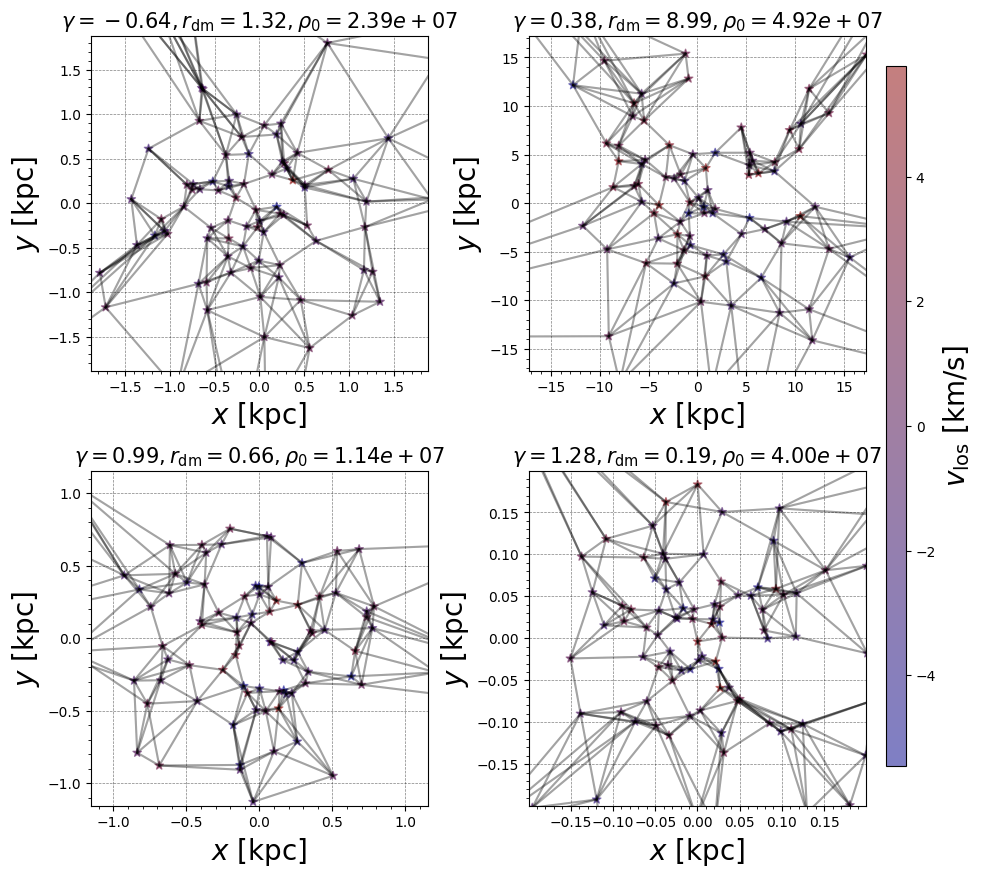

In [6]:
# randomly choose 4 galaxies
indices = np.random.randint(0, len(data_list), 4)

# start plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# some plotting parameters
s = 40
marker = '*'
# create a colormap by adding gradients between colors
color1 = 'darkblue'
color2 = 'darkred'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [color1, color2])

for i, idx in enumerate(indices):
    ax = axes[i // 2, i % 2]

    # get a random galaxy and transform it to a graph
    pos = data_list[idx].pos.numpy()  # 2d positions
    vel = data_list[idx].x[:, 1].numpy()  # los velocity
    labels = data_list[idx].y[0].numpy()

    data = transform(pos, vel)

    # set title to be parameters gamma, r_dm, rho_0,
    title = r'$\gamma={:.2f}, r_{{\rm dm}}={:.2f}, \rho_0={:.2e}$'.format(
        labels[0], 10**labels[1], 10**labels[2])
    box_size = 2 * 10**labels[3]

    # create a log scale for the colorbar
    norm = mpl.colors.Normalize(vmin=vel.min(), vmax=vel.max())

    # plot the nodes
    sc = ax.scatter(pos[:, 0], pos[:, 1], c=vel, norm=norm, s=s, 
                    marker=marker, cmap=cmap, alpha=0.5)
    ax.set_xlim(-box_size, box_size)
    ax.set_ylim(-box_size, box_size)

    # plot the edges
    for i in range(data.edge_index.shape[1]):
        x1, y1 = data.pos[data.edge_index[0, i]]
        x2, y2 = data.pos[data.edge_index[1, i]]
        ax.plot([x1, x2], [y1, y2], c='black', alpha=0.2)

    # add labels
    ax.set_xlabel(r'$x$ [kpc]', fontsize=20)  
    ax.set_ylabel(r'$y$ [kpc]', fontsize=20)
    ax.set_title(title, fontsize=15)

    # add major grid and minor ticks
    ax.grid(which='major', linestyle='--', linewidth='0.5', 
            alpha=0.5, color='black')
    ax.minorticks_on()

# add a colorbar to the right of the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label(r'$v_{\rm los}$ [km/s]', fontsize=20)

# adjust the spacing between subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

## Training

We will now train a GraphRegressor model to predict the dark matter halo 
density based on the projected galaxy kinematics. Using JeansGNN, we can easily construct a GraphRegressor model with the `im.gnn_im.GNNInferenceModel` wrapper.

First, we construct a `GNNInferenceModel` object from a config file.
The config file is a yaml file that contains all the parameters for the model. 
An example config file is provided in `example_training.yaml`

In [7]:
inference_model = jgnn.im.gnn_im.GNNInferenceModel(
    run_name='example_training', 
    config_file='example_training.yaml')

Alternatively, we can also construct a DensitySampler object from a dictionary.
The dictionary should contain all the parameters for the model.

In [9]:
# In this example, we read the config file and convert it to a dictionary
with open('example_training.yaml', 'r') as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
model_params = config_dict['model']
optimizer_params = config_dict['optimizer']
scheduler_params = config_dict['scheduler']

# Construct a DensitySampler object
# Note that if resume=False, the DensitySampler will overwrite
# the existing run directory
inference_model = jgnn.im.gnn_im.GNNInferenceModel(
    run_name='example_training',
    model_params=model_params,
    optimizer_params=optimizer_params,
    scheduler_params=scheduler_params,
    resume=False
)

Now we can start training!

In this simple example, we will train for 100 epochs and 
save the best model based on the validation loss.

If a GPU is available, the DensitySampler will automatically
use it for training.

In [10]:
inference_model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=100,
    save_top_k=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | GraphRegressor | 441 K 
-----------------------------------------
441 K     Trainable params
0         Non-trainable params
441 K     Total params
1.765     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 30.01it/s, loss=15.6, v_num=]

Metric val_loss improved. New best score: 15.323


Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 29.32it/s, loss=15.4, v_num=]

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 15.235


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 24.61it/s, loss=15.2, v_num=]

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 15.139


Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 23.79it/s, loss=15, v_num=]  

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 15.024


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 22.81it/s, loss=14.8, v_num=]

Metric val_loss improved by 0.237 >= min_delta = 0.0. New best score: 14.787


Epoch 5: 100%|██████████| 4/4 [00:00<00:00, 22.95it/s, loss=14.7, v_num=]

Metric val_loss improved by 0.291 >= min_delta = 0.0. New best score: 14.495


Epoch 6: 100%|██████████| 4/4 [00:00<00:00, 23.08it/s, loss=14.4, v_num=]

Metric val_loss improved by 0.392 >= min_delta = 0.0. New best score: 14.103


Epoch 7: 100%|██████████| 4/4 [00:00<00:00, 25.30it/s, loss=14.1, v_num=]

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 13.994


Epoch 8: 100%|██████████| 4/4 [00:00<00:00, 24.20it/s, loss=13.8, v_num=]

Metric val_loss improved by 0.454 >= min_delta = 0.0. New best score: 13.539


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 22.77it/s, loss=13.5, v_num=]

Metric val_loss improved by 0.438 >= min_delta = 0.0. New best score: 13.102


Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 22.79it/s, loss=13.1, v_num=]

Metric val_loss improved by 0.365 >= min_delta = 0.0. New best score: 12.737


Epoch 11: 100%|██████████| 4/4 [00:00<00:00, 22.88it/s, loss=12.8, v_num=]

Metric val_loss improved by 0.502 >= min_delta = 0.0. New best score: 12.235


Epoch 12: 100%|██████████| 4/4 [00:00<00:00, 27.53it/s, loss=12.5, v_num=]

Metric val_loss improved by 0.310 >= min_delta = 0.0. New best score: 11.924


Epoch 13: 100%|██████████| 4/4 [00:00<00:00, 23.98it/s, loss=12.2, v_num=]

Metric val_loss improved by 0.840 >= min_delta = 0.0. New best score: 11.084


Epoch 16: 100%|██████████| 4/4 [00:00<00:00, 20.69it/s, loss=11.1, v_num=]

Metric val_loss improved by 0.557 >= min_delta = 0.0. New best score: 10.527


Epoch 17: 100%|██████████| 4/4 [00:00<00:00, 23.77it/s, loss=10.8, v_num=]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 10.467


Epoch 18: 100%|██████████| 4/4 [00:00<00:00, 24.52it/s, loss=10.4, v_num=]

Metric val_loss improved by 0.653 >= min_delta = 0.0. New best score: 9.813


Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 26.17it/s, loss=9.52, v_num=]

Metric val_loss improved by 0.757 >= min_delta = 0.0. New best score: 9.056


Epoch 21: 100%|██████████| 4/4 [00:00<00:00, 23.91it/s, loss=9.14, v_num=]

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 8.943


Epoch 23: 100%|██████████| 4/4 [00:00<00:00, 25.60it/s, loss=8.4, v_num=] 

Metric val_loss improved by 0.445 >= min_delta = 0.0. New best score: 8.498


Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 21.17it/s, loss=8.08, v_num=]

Metric val_loss improved by 0.364 >= min_delta = 0.0. New best score: 8.134


Epoch 27: 100%|██████████| 4/4 [00:00<00:00, 26.68it/s, loss=7.26, v_num=]

Metric val_loss improved by 0.905 >= min_delta = 0.0. New best score: 7.228


Epoch 28: 100%|██████████| 4/4 [00:00<00:00, 26.33it/s, loss=7, v_num=]   

Metric val_loss improved by 0.612 >= min_delta = 0.0. New best score: 6.616


Epoch 31: 100%|██████████| 4/4 [00:00<00:00, 28.05it/s, loss=6.17, v_num=]

Metric val_loss improved by 0.626 >= min_delta = 0.0. New best score: 5.990


Epoch 32: 100%|██████████| 4/4 [00:00<00:00, 25.93it/s, loss=5.94, v_num=]

Metric val_loss improved by 0.587 >= min_delta = 0.0. New best score: 5.402


Epoch 40: 100%|██████████| 4/4 [00:00<00:00, 24.66it/s, loss=4.5, v_num=] 

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 5.351


Epoch 41: 100%|██████████| 4/4 [00:00<00:00, 23.66it/s, loss=4.23, v_num=]

Metric val_loss improved by 0.850 >= min_delta = 0.0. New best score: 4.501


Epoch 42: 100%|██████████| 4/4 [00:00<00:00, 26.66it/s, loss=3.98, v_num=]

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 4.381


Epoch 46: 100%|██████████| 4/4 [00:00<00:00, 24.12it/s, loss=3.13, v_num=]

Metric val_loss improved by 1.212 >= min_delta = 0.0. New best score: 3.169


Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 21.53it/s, loss=3.11, v_num=]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 3.154


Epoch 61: 100%|██████████| 4/4 [00:00<00:00, 25.97it/s, loss=2.87, v_num=]

Metric val_loss improved by 0.925 >= min_delta = 0.0. New best score: 2.229


Epoch 68: 100%|██████████| 4/4 [00:00<00:00, 28.08it/s, loss=1.29, v_num=]

Metric val_loss improved by 0.741 >= min_delta = 0.0. New best score: 1.488


Epoch 88: 100%|██████████| 4/4 [00:00<00:00, 24.29it/s, loss=0.702, v_num=]

Monitored metric val_loss did not improve in the last 20 records. Best score: 1.488. Signaling Trainer to stop.


Epoch 88: 100%|██████████| 4/4 [00:00<00:00, 20.87it/s, loss=0.702, v_num=]


After training, as an example, we sample the DM density of each galaxy in the validation set.

For this tutorial, we will show how to reload the trained model using `DensitySampler.load_from_dir()`

In [12]:
# We can reload the model using either `run_dir` or a combination of
# `run_name` and `run_dir`. DensitySampler will automatically find the
# best model based on the validation loss.
inference_model = jgnn.im.gnn_im.GNNInferenceModel.load_from_dir(
    run_dir='example_training'
)
# inference_model = jgnn.im.gnn_im.GNNInferenceModel.load_from_dir(
    # run_name='example_training', run_prefix=''
# )

In [13]:
num_samples = 1000  # number of posterior samples
posteriors, truths = inference_model.sample(
    data_loader=val_loader,
    num_samples=num_samples,
    return_labels=True,
)

We use the `corner` package to plot the corner plot of the predicted
DM density and the truth DM density.

API Reference for `corner` package: https://corner.readthedocs.io/en/latest/

In [14]:
import corner

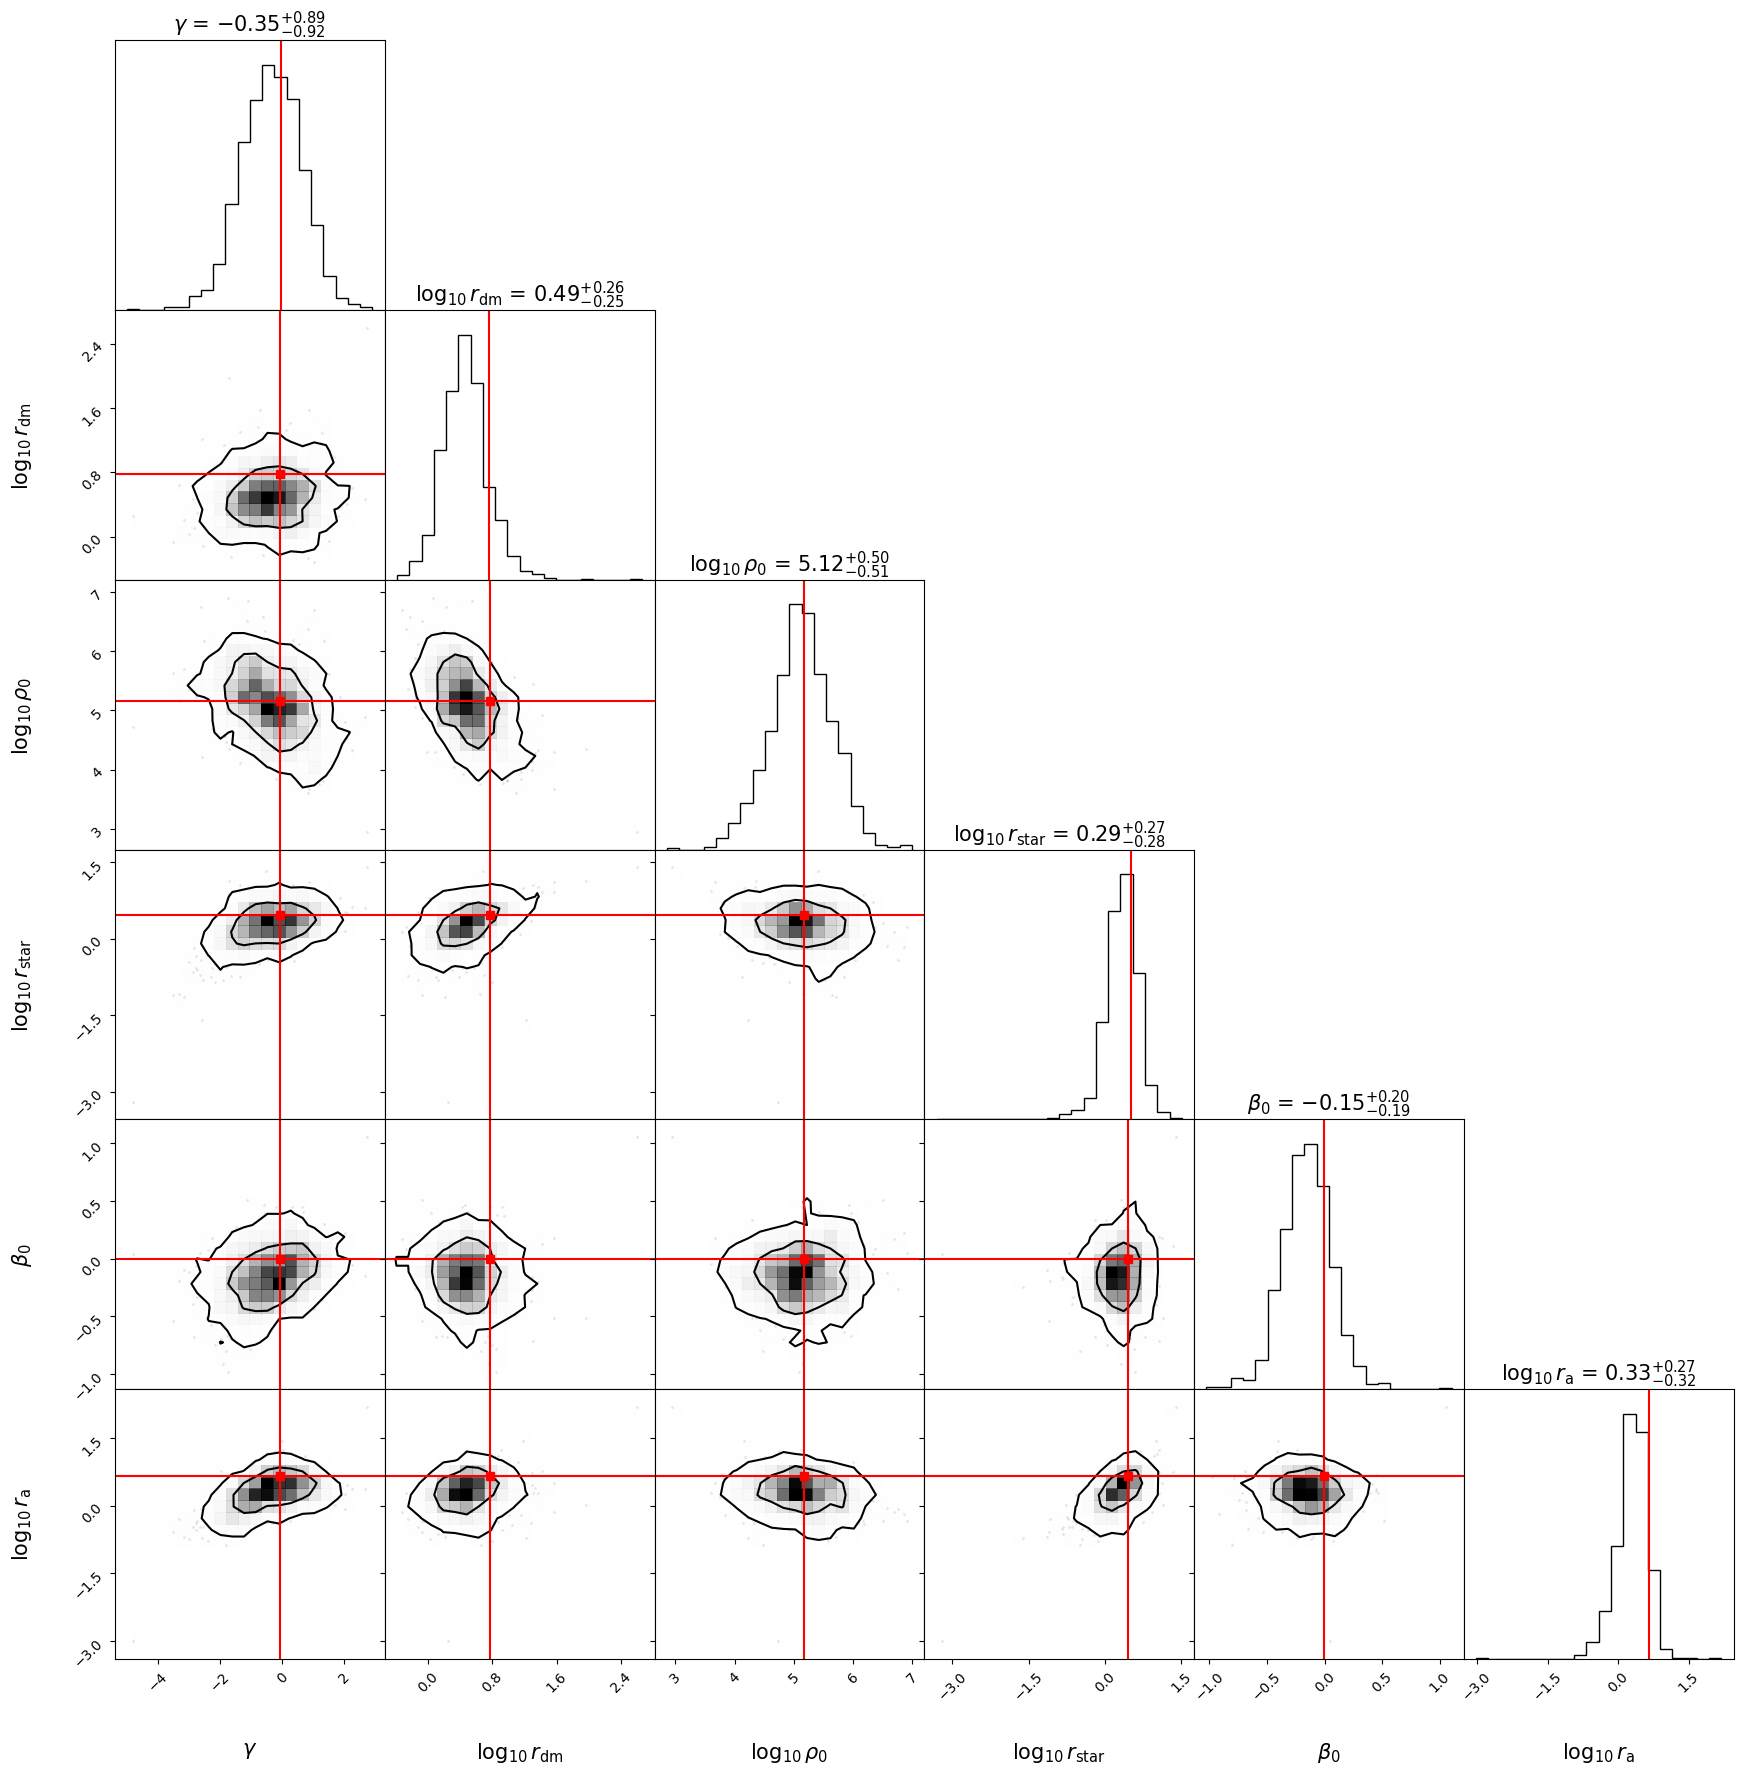

In [15]:
# plot corner plot of a chosen idx
idx = 0
labels = [
    r'$\gamma$', r'$\log_{10} r_{\rm dm}$', r'$\log_{10} \rho_0$', 
    r'$\log_{10} r_{\rm star}$', r'$\beta_0$', r'$\log_{10} r_{\rm a}$'
]
corner_args =dict(
    truth_color='red',
    labels=labels,
    show_titles=True,
    title_kwargs={'fontsize': 15},
    label_kwargs={'fontsize': 15},
    smooth=0.5,
    levels=(0.68, 0.95),
)

fig = plt.figure(figsize=(18, 18))
fig = corner.corner(
    posteriors[idx], truths=truths[idx],
    fig=fig, **corner_args
)
fig.subplots_adjust(wspace=0, hspace=0)

This looks pretty good for such a small training set! The predicted DM density is consistent with the truth.